In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn import preprocessing

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on GPU')
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('Running on CPU')

Running on GPU
NVIDIA GeForce GTX 1050 Ti with Max-Q Design


In [3]:
s_dir = './Stocks/CDNS_5y_12-23-21.csv'
#s_dir = './Stocks/CDNS.csv'

In [4]:
data = pd.read_csv(s_dir)

In [7]:
print(data.tail())
print(data.info())

            Date        Open        High         Low       Close   Adj Close  \
1252  2021-12-15  176.699997  184.410004  176.250000  184.270004  184.270004   
1253  2021-12-16  184.000000  184.009995  177.809998  179.619995  179.619995   
1254  2021-12-17  177.080002  182.449997  177.080002  179.149994  179.149994   
1255  2021-12-20  175.850006  178.619995  175.250000  177.320007  177.320007   
1256  2021-12-21  179.580002  183.289993  176.580002  183.029999  183.029999   

       Volume  
1252  1813100  
1253  1573400  
1254  3447100  
1255  1255100  
1256   980600  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1257 non-null   object 
 1   Open       1257 non-null   float64
 2   High       1257 non-null   float64
 3   Low        1257 non-null   float64
 4   Close      1257 non-null   float64
 5   Adj Close  1257 non-null   float

In [6]:
data.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

879

In [73]:
#Normalize datasets
#scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
#closed_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))



In [75]:
print(closed_data)
np_data = closed_data

[[0.00331492]
 [0.00405157]
 [0.00104359]
 ...
 [0.94493554]
 [0.93370173]
 [0.96875386]]


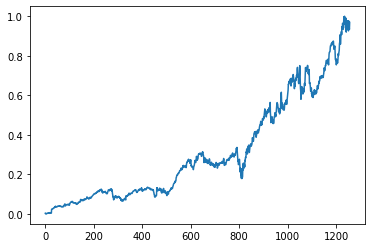

In [74]:
plt.plot(closed_data)

In [76]:
#split to train/test sets
split = int(len(data)*0.7)

np_train_set = np_data[:split]
np_test_set = np_data[split:]
#np_train_set

In [77]:
len(np_train_set)

879

In [48]:
len(np_test_set)

378

In [130]:
def create_RNN_dataset(data, seq_len):
        x, y = [], []
        total_len = len(data)
        for i in range(total_len-seq_len):
            x.append(data[i:i+seq_len])
            y.append(data[seq_len+i:seq_len+i+30])
        return x, y

In [136]:
sequence_l = 90

#list of numpy array
np_train_x, np_train_y = create_RNN_dataset(np_train_set, seq_len=sequence_l)
#print(np_train_x)
np_test_x, np_test_y = create_RNN_dataset(np_test_set, seq_len=sequence_l)

np_train_x, np_train_y = np.array(np_train_x), np.array(np_train_y)
np_test_x, np_test_y = np.array(np_test_x), np.array(np_test_y)
print(np_train_x.shape)
print(np_train_y.shape)

(789, 90, 1)
(789,)


C:\Users\brand\AppData\Local\Temp/ipykernel_2132/7688748.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np_train_x, np_train_y = np.array(np_train_x), np.array(np_train_y)
C:\Users\brand\AppData\Local\Temp/ipykernel_2132/7688748.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np_test_x, np_test_y = np.array(np_test_x), np.array(np_test_y)


In [134]:
#convert from np arry to pytorch tensor
train_x = torch.tensor(np.array(np_train_x)).float() # convert list of numpy array to numpy array
print(train_x.size())
train_y = torch.tensor(np.array(np_train_y)).squeeze().float()
test_x = torch.tensor(np.array(np_test_x)).float()
test_y = torch.tensor(np.array(np_test_y)).squeeze().float()
#print(train_x.size())


torch.Size([789, 90, 1])


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [82]:
print(train_x[800, :, :])

tensor([[0.2517],
        [0.2766],
        [0.2616],
        [0.2425],
        [0.2120],
        [0.2314],
        [0.2272],
        [0.1947],
        [0.2287],
        [0.1804],
        [0.2070],
        [0.1786],
        [0.1872],
        [0.1833],
        [0.1881],
        [0.2340],
        [0.2218],
        [0.2561],
        [0.2275],
        [0.2559],
        [0.2506],
        [0.2457],
        [0.2499],
        [0.2376],
        [0.2713],
        [0.2691],
        [0.2862],
        [0.2850],
        [0.2844],
        [0.3138]])


In [126]:
class LSTM(nn.Module):
    def __init__(self, i_size, h_size, n_layers, drop):
        super(LSTM, self).__init__()
        self.num_layers = n_layers
        self.hidden_dim = h_size
        self.lstm = nn.LSTM(input_size=i_size, hidden_size=h_size, num_layers=n_layers, batch_first=True, dropout=drop)
        self.layer1 = nn.Linear(h_size, 1)
    
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        output, _ = self.lstm(x, (h0, c0))
        #x = F.relu(self.layer1(x))
        output = self.layer1(output[-1,:,:])
        return output
        

In [127]:
stock = LSTM(1, 32, 2, 0)
stock.to(device)

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (layer1): Linear(in_features=32, out_features=1, bias=True)
)

In [114]:
#Loss Function
loss_func = nn.MSELoss()

In [118]:
#Optimizer
optimizer = torch.optim.Adam(stock.parameters(), lr=0.01)

In [117]:
#Train Function
def train(model, batch_size, loss_f, optimizer, device):
    losses = []
    model.train()
    
    total_batches = int(len(train_x[0])/batch_size)
    
    for batch_n in range (total_batches):
        optimizer.zero_grad()
        inputs = train_x[:,batch_n*batch_size:(batch_n+1)*batch_size]
        labels = train_y[batch_n*batch_size:(batch_n+1)*batch_size]
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = loss_f(outputs, labels)
        loss.backward()
        losses.append(loss)
        optimizer.step()
    #print('Loss: ', losses)
    #print('End of epoch loss:', round((sum(losses)/len(train_x)).item(), 3))

In [124]:
#Test Function
def test(model, batch_size, device):
    model.eval()

    total_batches = int(len(test_x[0])/batch_size)
    
    for batch_n in range(total_batches):
        inputs = test_x[:,batch_n*batch_size:(batch_n+1)*batch_size]
        labels = test_y[batch_n*batch_size:(batch_n+1)*batch_size]
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        prediction = model(inputs)
        #print('pred:', prediction.size())
        print('pred:', prediction)
        #correct += (prediction == labels).sum().item()
        
        #print('pred: ', prediction)
        print('actual: ', labels)
        #print('Expected: ', labels)
    #print('End of epoch accuracy:', 100*correct/len(test_x), '%')

In [128]:
#Train/Test Script
for epoch in range(1,101):
    print('Epoch: ', epoch)
    train(stock, 30, loss_func, optimizer, device)
    test(stock, 30, device)

Epoch:  1
pred: tensor([[-0.1411],
        [-0.1343],
        [-0.1291],
        [-0.1249],
        [-0.1218],
        [-0.1195],
        [-0.1179],
        [-0.1167],
        [-0.1160],
        [-0.1155],
        [-0.1151],
        [-0.1149],
        [-0.1147],
        [-0.1146],
        [-0.1145],
        [-0.1144],
        [-0.1144],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1142],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143]], device='cuda:0', grad_fn=<AddmmBackward0>)
actual:  tensor([0.5236, 0.5114, 0.5032, 0.4909, 0.5037, 0.5122, 0.5082, 0.5175, 0.5152,
        0.5114, 0.5282, 0.5239, 0.5283, 0.5282, 0.5368, 0.5165, 0.5257, 0.5260,
        0.5449, 0.5640, 0.5085, 0.4952, 0.4618, 0.4857, 0.4727, 0.4683, 0.4789,
        0.4912, 0.4747, 0.4661], device='cuda:0')
Epoch:  2
pred: tensor([[-0.1411],
        [-0.1343],
        [-0.1291]

pred: tensor([[-0.1411],
        [-0.1343],
        [-0.1291],
        [-0.1249],
        [-0.1218],
        [-0.1195],
        [-0.1179],
        [-0.1167],
        [-0.1160],
        [-0.1155],
        [-0.1151],
        [-0.1149],
        [-0.1147],
        [-0.1146],
        [-0.1145],
        [-0.1144],
        [-0.1144],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1142],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143]], device='cuda:0', grad_fn=<AddmmBackward0>)
actual:  tensor([0.5236, 0.5114, 0.5032, 0.4909, 0.5037, 0.5122, 0.5082, 0.5175, 0.5152,
        0.5114, 0.5282, 0.5239, 0.5283, 0.5282, 0.5368, 0.5165, 0.5257, 0.5260,
        0.5449, 0.5640, 0.5085, 0.4952, 0.4618, 0.4857, 0.4727, 0.4683, 0.4789,
        0.4912, 0.4747, 0.4661], device='cuda:0')
Epoch:  13
pred: tensor([[-0.1411],
        [-0.1343],
        [-0.1291],
       

pred: tensor([[-0.1411],
        [-0.1343],
        [-0.1291],
        [-0.1249],
        [-0.1218],
        [-0.1195],
        [-0.1179],
        [-0.1167],
        [-0.1160],
        [-0.1155],
        [-0.1151],
        [-0.1149],
        [-0.1147],
        [-0.1146],
        [-0.1145],
        [-0.1144],
        [-0.1144],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1142],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143]], device='cuda:0', grad_fn=<AddmmBackward0>)
actual:  tensor([0.5236, 0.5114, 0.5032, 0.4909, 0.5037, 0.5122, 0.5082, 0.5175, 0.5152,
        0.5114, 0.5282, 0.5239, 0.5283, 0.5282, 0.5368, 0.5165, 0.5257, 0.5260,
        0.5449, 0.5640, 0.5085, 0.4952, 0.4618, 0.4857, 0.4727, 0.4683, 0.4789,
        0.4912, 0.4747, 0.4661], device='cuda:0')
Epoch:  23
pred: tensor([[-0.1411],
        [-0.1343],
        [-0.1291],
       

pred: tensor([[-0.1411],
        [-0.1343],
        [-0.1291],
        [-0.1249],
        [-0.1218],
        [-0.1195],
        [-0.1179],
        [-0.1167],
        [-0.1160],
        [-0.1155],
        [-0.1151],
        [-0.1149],
        [-0.1147],
        [-0.1146],
        [-0.1145],
        [-0.1144],
        [-0.1144],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1142],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143]], device='cuda:0', grad_fn=<AddmmBackward0>)
actual:  tensor([0.5236, 0.5114, 0.5032, 0.4909, 0.5037, 0.5122, 0.5082, 0.5175, 0.5152,
        0.5114, 0.5282, 0.5239, 0.5283, 0.5282, 0.5368, 0.5165, 0.5257, 0.5260,
        0.5449, 0.5640, 0.5085, 0.4952, 0.4618, 0.4857, 0.4727, 0.4683, 0.4789,
        0.4912, 0.4747, 0.4661], device='cuda:0')
Epoch:  35
pred: tensor([[-0.1411],
        [-0.1343],
        [-0.1291],
       

pred: tensor([[-0.1411],
        [-0.1343],
        [-0.1291],
        [-0.1249],
        [-0.1218],
        [-0.1195],
        [-0.1179],
        [-0.1167],
        [-0.1160],
        [-0.1155],
        [-0.1151],
        [-0.1149],
        [-0.1147],
        [-0.1146],
        [-0.1145],
        [-0.1144],
        [-0.1144],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1142],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143]], device='cuda:0', grad_fn=<AddmmBackward0>)
actual:  tensor([0.5236, 0.5114, 0.5032, 0.4909, 0.5037, 0.5122, 0.5082, 0.5175, 0.5152,
        0.5114, 0.5282, 0.5239, 0.5283, 0.5282, 0.5368, 0.5165, 0.5257, 0.5260,
        0.5449, 0.5640, 0.5085, 0.4952, 0.4618, 0.4857, 0.4727, 0.4683, 0.4789,
        0.4912, 0.4747, 0.4661], device='cuda:0')
Epoch:  45
pred: tensor([[-0.1411],
        [-0.1343],
        [-0.1291],
       

pred: tensor([[-0.1411],
        [-0.1343],
        [-0.1291],
        [-0.1249],
        [-0.1218],
        [-0.1195],
        [-0.1179],
        [-0.1167],
        [-0.1160],
        [-0.1155],
        [-0.1151],
        [-0.1149],
        [-0.1147],
        [-0.1146],
        [-0.1145],
        [-0.1144],
        [-0.1144],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1142],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143]], device='cuda:0', grad_fn=<AddmmBackward0>)
actual:  tensor([0.5236, 0.5114, 0.5032, 0.4909, 0.5037, 0.5122, 0.5082, 0.5175, 0.5152,
        0.5114, 0.5282, 0.5239, 0.5283, 0.5282, 0.5368, 0.5165, 0.5257, 0.5260,
        0.5449, 0.5640, 0.5085, 0.4952, 0.4618, 0.4857, 0.4727, 0.4683, 0.4789,
        0.4912, 0.4747, 0.4661], device='cuda:0')
Epoch:  55
pred: tensor([[-0.1411],
        [-0.1343],
        [-0.1291],
       

pred: tensor([[-0.1411],
        [-0.1343],
        [-0.1291],
        [-0.1249],
        [-0.1218],
        [-0.1195],
        [-0.1179],
        [-0.1167],
        [-0.1160],
        [-0.1155],
        [-0.1151],
        [-0.1149],
        [-0.1147],
        [-0.1146],
        [-0.1145],
        [-0.1144],
        [-0.1144],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1142],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143]], device='cuda:0', grad_fn=<AddmmBackward0>)
actual:  tensor([0.5236, 0.5114, 0.5032, 0.4909, 0.5037, 0.5122, 0.5082, 0.5175, 0.5152,
        0.5114, 0.5282, 0.5239, 0.5283, 0.5282, 0.5368, 0.5165, 0.5257, 0.5260,
        0.5449, 0.5640, 0.5085, 0.4952, 0.4618, 0.4857, 0.4727, 0.4683, 0.4789,
        0.4912, 0.4747, 0.4661], device='cuda:0')
Epoch:  65
pred: tensor([[-0.1411],
        [-0.1343],
        [-0.1291],
       

pred: tensor([[-0.1411],
        [-0.1343],
        [-0.1291],
        [-0.1249],
        [-0.1218],
        [-0.1195],
        [-0.1179],
        [-0.1167],
        [-0.1160],
        [-0.1155],
        [-0.1151],
        [-0.1149],
        [-0.1147],
        [-0.1146],
        [-0.1145],
        [-0.1144],
        [-0.1144],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1142],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143]], device='cuda:0', grad_fn=<AddmmBackward0>)
actual:  tensor([0.5236, 0.5114, 0.5032, 0.4909, 0.5037, 0.5122, 0.5082, 0.5175, 0.5152,
        0.5114, 0.5282, 0.5239, 0.5283, 0.5282, 0.5368, 0.5165, 0.5257, 0.5260,
        0.5449, 0.5640, 0.5085, 0.4952, 0.4618, 0.4857, 0.4727, 0.4683, 0.4789,
        0.4912, 0.4747, 0.4661], device='cuda:0')
Epoch:  75
pred: tensor([[-0.1411],
        [-0.1343],
        [-0.1291],
       

actual:  tensor([0.5236, 0.5114, 0.5032, 0.4909, 0.5037, 0.5122, 0.5082, 0.5175, 0.5152,
        0.5114, 0.5282, 0.5239, 0.5283, 0.5282, 0.5368, 0.5165, 0.5257, 0.5260,
        0.5449, 0.5640, 0.5085, 0.4952, 0.4618, 0.4857, 0.4727, 0.4683, 0.4789,
        0.4912, 0.4747, 0.4661], device='cuda:0')
Epoch:  84
pred: tensor([[-0.1411],
        [-0.1343],
        [-0.1291],
        [-0.1249],
        [-0.1218],
        [-0.1195],
        [-0.1179],
        [-0.1167],
        [-0.1160],
        [-0.1155],
        [-0.1151],
        [-0.1149],
        [-0.1147],
        [-0.1146],
        [-0.1145],
        [-0.1144],
        [-0.1144],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1142],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143]], device='cuda:0', grad_fn=<AddmmBackward0>)
actual:  tensor([0.5236, 0.5114, 0.5032, 0.4909, 0.5037, 0.5122, 0.508

actual:  tensor([0.5236, 0.5114, 0.5032, 0.4909, 0.5037, 0.5122, 0.5082, 0.5175, 0.5152,
        0.5114, 0.5282, 0.5239, 0.5283, 0.5282, 0.5368, 0.5165, 0.5257, 0.5260,
        0.5449, 0.5640, 0.5085, 0.4952, 0.4618, 0.4857, 0.4727, 0.4683, 0.4789,
        0.4912, 0.4747, 0.4661], device='cuda:0')
Epoch:  95
pred: tensor([[-0.1411],
        [-0.1343],
        [-0.1291],
        [-0.1249],
        [-0.1218],
        [-0.1195],
        [-0.1179],
        [-0.1167],
        [-0.1160],
        [-0.1155],
        [-0.1151],
        [-0.1149],
        [-0.1147],
        [-0.1146],
        [-0.1145],
        [-0.1144],
        [-0.1144],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1142],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143],
        [-0.1143]], device='cuda:0', grad_fn=<AddmmBackward0>)
actual:  tensor([0.5236, 0.5114, 0.5032, 0.4909, 0.5037, 0.5122, 0.508

In [ ]:
# save weights
torch.save(stock.state_dict(), "./StockModel.pt")

In [ ]:
#loader
stockModel = CNN()
modelWeights = torch.load("./StockModel.pt")
stockModel.load_state_dict(modelWeights)

In [66]:
m = nn.Sequential(
    nn.LSTM(input_size=30, hidden_size=20, num_layers=3, batch_first=True, dropout=0.2),
    #nn.Linear(20,10),
    #nn.Linear(10, 1)
    #nn.Conv2d(1,16,7,stride=1,padding=2),
    #nn.MaxPool2d(kernel_size=3, stride=3),
    #nn.Conv2d(16,32,7,stride=1,padding=1),
    #nn.MaxPool2d(kernel_size=5, stride=3),
    #nn.Conv2d(32,64,3,stride=1,padding=1),
    #nn.MaxPool2d(kernel_size=2, stride=2),
    #nn.Flatten()
)

In [75]:
inputs = torch.randn(30,10,1)
print(inputs)
#output, (h_0,c_0) = m(inputs)
#output.size()

tensor([[[ 1.0781e-01],
         [ 3.6962e-01],
         [-2.8077e-01],
         [ 8.9057e-02],
         [-1.1219e+00],
         [-6.7937e-01],
         [ 1.0048e+00],
         [-9.8230e-01],
         [-1.5039e+00],
         [-3.7228e-01]],

        [[ 1.1369e+00],
         [ 9.5619e-01],
         [ 7.6198e-04],
         [ 1.7247e-01],
         [ 2.9469e-01],
         [ 1.8378e-01],
         [ 9.6322e-02],
         [-1.7440e-01],
         [-1.4952e+00],
         [ 2.1246e-02]],

        [[-8.9841e-01],
         [-4.7508e-01],
         [-1.0861e+00],
         [-2.0132e-01],
         [-2.4031e+00],
         [ 2.8254e-01],
         [ 1.1632e+00],
         [ 4.5747e-01],
         [-5.5225e-01],
         [-1.8980e-01]],

        [[-1.2350e+00],
         [ 4.2118e-01],
         [ 6.5976e-01],
         [-1.2103e+00],
         [ 1.5877e+00],
         [-1.7155e-02],
         [-9.2476e-01],
         [ 5.2618e-01],
         [-1.1711e+00],
         [ 1.0142e+00]],

        [[ 1.5482e+00],
        